# Kaggle IEEE-CIS-FraudDetection Competition

* Data: [https://www.kaggle.com/c/ieee-fraud-detection/data](https://www.kaggle.com/c/ieee-fraud-detection/data)
* Feature Engineering and Model Learning Part

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc,os,sys
import re

from sklearn import metrics, preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

pd.options.display.float_format = '{:,.3f}'.format

In [2]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
trn_id = pd.read_csv('_input/train_identity.csv')
trn_tr = pd.read_csv('_input/train_transaction.csv')
tst_id = pd.read_csv('_input/test_identity.csv')
tst_tr = pd.read_csv('_input/test_transaction.csv')

id_cols = trn_id.columns.to_list()
trn_cols = trn_tr.drop('isFraud', axis=1).columns.tolist()

X_trn = pd.merge(trn_tr[['isFraud'] + trn_cols], trn_id[id_cols], how='left')
X_trn = reduce_mem_usage(X_trn)

X_tst = pd.merge(tst_tr[trn_cols], tst_id[id_cols], how='left')
X_tst = reduce_mem_usage(X_tst)

X_trn_id = X_trn.pop('TransactionID')
X_tst_id = X_tst.pop('TransactionID')

del trn_id, trn_tr, tst_id, tst_tr
gc.collect()

X_all = X_trn.append(X_tst, sort=False).reset_index(drop=True)

Memory usage of dataframe is 1959.00 MB --> 650.00 MB (Decreased by 66.0%)
Memory usage of dataframe is 1677.00 MB --> 565.00 MB (Decreased by 66.0%)


In [6]:
print(X_all.shape)

(1097231, 433)


In [7]:
vcols = ['V%d' % i for i in range(1, 340)]

sc = preprocessing.MinMaxScaler()
pca = PCA(n_components=2)

vcol_pca = pca.fit_transform(sc.fit_transform(X_all[vcols].fillna(-1)))

X_all['_vcol_pca0'] = vcol_pca[:, 0]
X_all['_vcol_pca1'] = vcol_pca[:, 1]
X_all['_vcol_nulls'] = X_all[vcols].isnull().sum(axis=1)

X_all.drop(vcols, axis=1, inplace=True)

In [8]:
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
X_all['Date'] = X_all['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
X_all['_weekday'] = X_all['Date'].dt.dayofweek
X_all['_hour'] = X_all['Date'].dt.hour
X_all['_day'] = X_all['Date'].dt.day

X_all['_weekday'] = X_all['_weekday'].astype(str)
X_all['_hour'] = X_all['_hour'].astype(str)
X_all['_weekday__hour'] = X_all['_weekday'] + X_all['_hour']

cnt_day = X_all['_day'].value_counts()
cnt_day = cnt_day / cnt_day.mean()
X_all['_count_rate'] = X_all['_day'].map(cnt_day.to_dict())

X_all.drop(['TransactionDT','Date','_day'], axis=1, inplace=True)

In [9]:
X_all['_card1__card2'] = X_all['card1'].astype(str) + '__' + X_all['card2'].astype(str)
X_all['_card_n'] = X_all['card1'].astype(str) + '__' + X_all['card2'].astype(str) + '__' + X_all['card3'].astype(str) + '__' + X_all['card5'].astype(str)

In [11]:
X_all['_card1__addr1'] = X_all['card1'].astype(str) + '__' + X_all['addr1'].astype(str)
X_all['_card2__addr1'] = X_all['card2'].astype(str) + '__' + X_all['addr1'].astype(str)
X_all['_card12__addr1'] = X_all['_card1__card2'] + '__' + X_all['addr1'].astype(str)
X_all['_card_all__addr1'] = X_all['_card1__card2'] + '__' + X_all['addr1'].astype(str)

X_all['_P_emaildomain__addr1'] = X_all['P_emaildomain'] + '__' + X_all['addr1'].astype(str)

In [12]:
X_all['_amount_decimal'] = ((X_all['TransactionAmt'] - X_all['TransactionAmt'].astype(int)) * 1000).astype(int)
X_all['_amount_decimal_len'] = X_all['TransactionAmt'].apply(lambda x: len(re.sub('0+$', '', str(x)).split('.')[1]))
X_all['_amount_fraction'] = X_all['TransactionAmt'].apply(lambda x: float('0.'+re.sub('^[0-9]|\.|0+$', '', str(x))))
X_all[['TransactionAmt','_amount_decimal','_amount_decimal_len','_amount_fraction']].head(10)

,TransactionAmt,_amount_decimal,_amount_decimal_len,_amount_fraction
0,68.500,500,1,0.850
1,29.000,0,0,0.900
2,59.000,0,0,0.900
3,50.000,0,0,0.000
4,50.000,0,0,0.000
5,49.000,0,0,0.900
6,159.000,0,0,0.590
7,422.500,500,1,0.225
8,15.000,0,0,0.500
9,117.000,0,0,0.170


In [13]:
cols = ['ProductCD', 'card1', 'card2', 'card5', 'card6', 'P_emaildomain', '_card_all__addr1', '_card_n']

# amount mean&std
for f in cols:
    X_all['_amount_mean_{}'.format(f)] = X_all['TransactionAmt'] / X_all.groupby([f])['TransactionAmt'].transform('mean')
    X_all['_amount_std_{}'.format(f)] = X_all['TransactionAmt'] / X_all.groupby([f])['TransactionAmt'].transform('std')
    X_all['_amount_pct_{}'.format(f)] = (X_all['TransactionAmt'] - X_all['_amount_mean_{}'.format(f)]) / X_all['_amount_std_{}'.format(f)]


# freq encoding
for f in cols:
    vc = X_all[f].value_counts(dropna=False)
    X_all['_freq_{}'.format(f)] = X_all[f].map(vc)
    

In [16]:

cat_cols = ['id_{:02d}'.format(i) for i in range(12, 39)]
for i in cat_cols:
    if i in X_all.columns:
        X_all[i] = X_all[i].astype(str)
        X_all[i].fillna('unknown', inplace=True)

enc_cols = []
for i, t in X_all.loc[:, X_all.columns != 'isFraud'].dtypes.iteritems():
    if t == object:
        enc_cols.append(i)
        #df = pd.concat([df, pd.get_dummies(df[i].astype(str), prefix=i)], axis=1)
        #df.drop(i, axis=1, inplace=True)
        X_all[i] = pd.factorize(X_all[i])[0]
        #X_all[i] = X_all[i].astype('category')
print(enc_cols)

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', '_weekday', '_hour', '_weekday__hour', '_card1__card2', '_card_n', '_card1__addr1', '_card2__addr1', '_card12__addr1', '_card_all__addr1', '_P_emaildomain__addr1']


In [18]:
X_trn = X_all[X_all['isFraud'].notnull()]
X_tst = X_all[X_all['isFraud'].isnull()].drop('isFraud', axis=1)
y_trn = X_trn.pop('isFraud')

print(X_trn.shape, y_trn.shape)
print(X_tst.shape)

((590540, 141), (590540,))
(506691, 141)


In [21]:
%%time

import lightgbm as lgb

params={'learning_rate': 0.01,
        'objective': 'binary',
        'metric': 'auc',
        'num_threads': -1,
        'num_leaves': 256,
        'verbose': 1,
        'random_state': 42,
        'bagging_fraction': 1,
        'feature_fraction': 0.85,
        'n_estimators': 1000
       }


clf = lgb.LGBMClassifier(**params)
clf.fit(X_trn, y_trn)

p_trn = clf.predict_proba(X_trn, num_iteration=clf.best_iteration_)[:,1]
p_tst = clf.predict_proba(X_tst, num_iteration=clf.best_iteration_)[:,1]

CPU times: user 40min 9s, sys: 31.7 s, total: 40min 41s
Wall time: 11min 11s


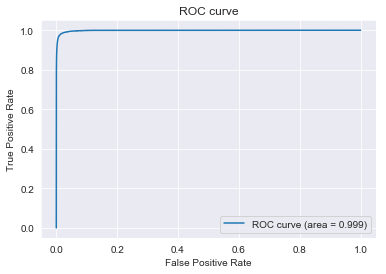

In [22]:
fpr, tpr, thresholds = metrics.roc_curve(y_trn, p_trn)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.3f)' % auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

plt.show()

In [23]:
def get_importances(clf):
    feature_importance = clf.feature_importances_
    feature_importance = 100 * feature_importance / feature_importance.max()

    sorted_idx = np.argsort(feature_importance)
    sorted_idx = sorted_idx[-50:]
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=(10,12))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_trn.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

    data = pd.DataFrame(feature_importance[sorted_idx], index=X_trn.columns[sorted_idx])
    return data

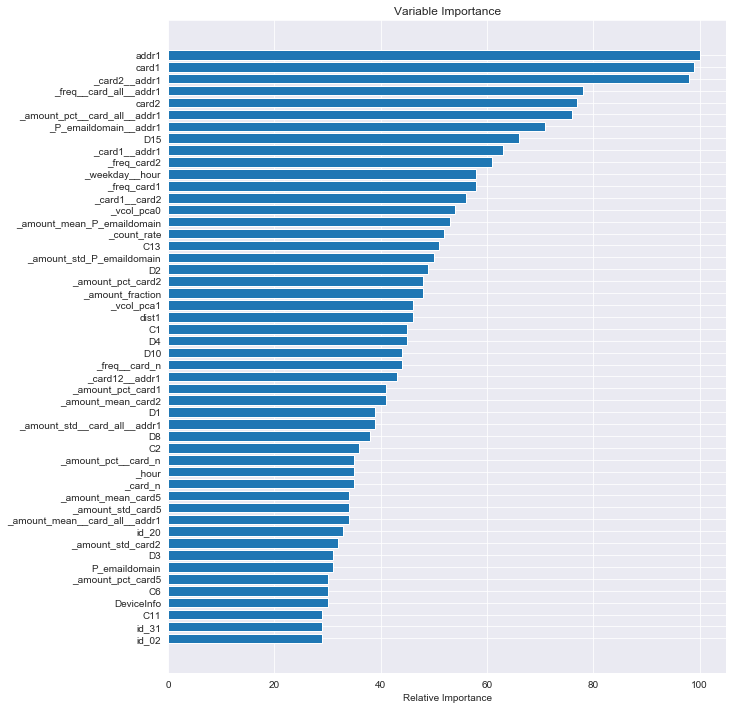

In [24]:
_ = get_importances(clf)

In [25]:
import time

def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0.
    auc = 0.
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

def eval_auc (preds, dtrain):
    labels = dtrain.get_label()    
    return 'auc', fast_auc(labels, preds), True


def cross_validate_lgb(param, X_trn, y_trn, X_tst, kf,  
                       num_boost_round, 
                       fname='submission', nseed=1, verbose_eval=1,
                       featimp=False, save_pred=False,
                       use_auc=True,
                       early_stopping_rounds=150,
                       use_all_folds=True,
                       ):
    
    if save_pred:
        now = datetime.datetime.now()
        now = str(now.strftime('%Y-%m-%d-%H-%M-%S'))
#         print 'started at:', now
        print 'num bagging seeds:', nseed
        fname = '_output/'+fname+'_'+now
        print 'data size:', X_trn.shape, X_tst.shape
        
    
    nfold = kf.n_splits
    print 'nfold:', nfold
        
    val_pred = np.zeros((X_trn.shape[0], nseed))
    test_pred = np.zeros((X_tst.shape[0], nfold * nseed))
        
    print 'num features:', X_trn.shape[1]
    
    d_train = lgb.Dataset(X_trn.values, label=y_trn)
    if use_auc:
        metric = 'auc'
    else:
        metric = None
    history = lgb.cv(params, d_train, num_boost_round=num_boost_round, 
                     folds=kf, metrics=metric, fobj=None,
                     early_stopping_rounds=early_stopping_rounds, 
                     verbose_eval=verbose_eval, show_stdv=True, seed=0)
    if use_auc:
        best_round = np.argmax(history['auc-mean'])
    else:
        best_round = np.argmin(history['binary_logloss-mean'])
    print 'best_round:', best_round
    if best_round == 0:
        best_round = 1
        
    bsts = []
    for i, (train_index, test_index) in enumerate(kf.split(X_trn, y_trn)):
        print 'train fold', i,
        X_trn_kf, X_tst_kf = X_trn.loc[train_index,:].copy(), X_trn.loc[test_index,:].copy()
        y_trn_kf, y_test_kf = y_trn[train_index], y_trn[test_index]

        d_train_kf = lgb.Dataset(X_trn_kf, label=y_trn_kf)
        d_test_kf = lgb.Dataset(X_tst_kf, label=y_test_kf)
        
        train_fold_pred = 0
        
        feval = None
        if use_auc:
            feval=eval_auc
        for seed in range(nseed):
            param['seed'] = seed
            
            bst = lgb.train(param, d_train_kf, num_boost_round=best_round,
                            verbose_eval=None,
                            early_stopping_rounds=None, 
                            )

            bsts.append(bst)
            pred = bst.predict(X_tst_kf)
            val_pred[test_index, seed] = (pred)
            pred = bst.predict(X_tst)
            test_pred[:, i*nseed + seed] = (pred)
            train_fold_pred = train_fold_pred + bst.predict(X_trn_kf)
            print '.',
            
        train_fold_pred /= nseed
        print 'train auc: %0.5f' % fast_auc(y_trn_kf, train_fold_pred),
        val_fold_pred = np.mean(val_pred[test_index,:], axis=1)  
        print 'val auc: %0.5f' % fast_auc(y_test_kf, val_fold_pred)
        del d_train_kf
        del d_test_kf
        gc.collect()
        if featimp:
            importances = get_importances(bsts)
            plt.show()
        else:
            importances = None
        if use_all_folds == False:
            break
    
    
    print 'saving raw train prediction to:', fname+'_train.npy'
    np.save(fname+'_train.npy', val_pred)
    print 'saving raw test prediction to:', fname+'_test.npy'
    np.save(fname+'_test.npy', test_pred)
    
    epsilon = 1e-6

    train_expit = (val_pred + epsilon - val_pred.ravel().min())
    test_expit = (test_pred + epsilon - test_pred.ravel().min())
    train_expit /= (epsilon + train_expit.ravel().max())
    test_expit /= (epsilon + test_expit.ravel().max())
    
    train_pred_mean = np.mean(train_expit, axis=1)
    test_pred_mean = np.mean(test_expit, axis=1)        
    print 'cv       mean auc:%0.5f' % fast_auc(y_trn, train_pred_mean)
    print 'saving mean test prediction ...'
    mysub(X_tst_id, test_pred.mean(axis=1))

    if featimp:
        importances = get_importances(bsts)
    else:
        importances = None

    return importances, val_pred, test_pred, bsts, fname

def mysub(sub_id, sub_preds):
    dirname = '_output/'
    timestr = time.strftime('%Y%m%d-%H%M%S')
    filename = dirname + 'submission_' + timestr + '.csv'

    submission = pd.DataFrame()
    submission['TransactionID'] = sub_id
    submission['isFraud'] = sub_preds
    submission.to_csv(filename, index=False)
    return 


In [26]:
kf = StratifiedKFold(5, shuffle=True, random_state=7)

params={'learning_rate': 0.01,
        'objective': 'binary',
        'metric': 'auc',
        'num_threads': -1,
        'num_leaves': 256,
        'verbose': 1,
        'random_state': 42,
        'bagging_fraction': 1,
        'feature_fraction': 0.85
       }


In [28]:
(importances_reglinear, train_pred_reglinear, test_pred_reglinear, bsts, fname_save)= cross_validate_lgb(params, X_trn, y_trn, X_tst, kf,  
                     num_boost_round=3000, 
                     verbose_eval=100,
                     featimp=False, save_pred=True,
                     use_auc=True,
                     early_stopping_rounds=150
                     )

started at: 2019-10-09-00-27-51
num bagging seeds: 1
data size: (590540, 141) (506691, 141)
nfold: 5
num features: 141
[100]	cv_agg's auc: 0.919066 + 0.00319689
[200]	cv_agg's auc: 0.938524 + 0.0023906
[300]	cv_agg's auc: 0.951088 + 0.00151243
[400]	cv_agg's auc: 0.958836 + 0.00141831
[500]	cv_agg's auc: 0.963309 + 0.00147379
[600]	cv_agg's auc: 0.966058 + 0.00149629
[700]	cv_agg's auc: 0.967754 + 0.00150459
[800]	cv_agg's auc: 0.968983 + 0.00151162
[900]	cv_agg's auc: 0.97003 + 0.00148938
[1000]	cv_agg's auc: 0.9709 + 0.00147409
[1100]	cv_agg's auc: 0.971605 + 0.00143275
[1200]	cv_agg's auc: 0.972234 + 0.00140673
[1300]	cv_agg's auc: 0.972799 + 0.00140929
[1400]	cv_agg's auc: 0.973304 + 0.00135341
[1500]	cv_agg's auc: 0.973727 + 0.00135193
[1600]	cv_agg's auc: 0.974101 + 0.00132953
[1700]	cv_agg's auc: 0.974445 + 0.00129362
[1800]	cv_agg's auc: 0.974706 + 0.00130046
[1900]	cv_agg's auc: 0.974961 + 0.0013234
[2000]	cv_agg's auc: 0.975165 + 0.0013112
[2100]	cv_agg's auc: 0.975335 + 0.00